# H2 visa application data analysis

* Description
* Dataset
* Goal 
* Imports
* Data exploration
* Initial visualizations
* Data cleaning
* Visualization after the cleaning
* Goal - How has the number of approved applications changed over time?
* Goal - How have the number of approved workers changed over time?
* Goal - Which locations and types of businesses request the most visas and how has this changed over time?
* Goal - Which positions are the most frequently requested for these visas? 
* Goal - Is there a correlation between the length of the period the employee is expected to work for and the final decision?


## Description

H2 visa applications are requests by companies to hire foreign workers for nonagricultural jobs within the United States. The U.S. Department of Labor releases this data as Excel (.XLS) files and BuzzFeed News has been tracking and hosting these datasets on Github. The dataset we’ll be working with represents H2 applications from October 1, 2010 to March 31, 2016.

This is a weekly challenge done as a part of Data Science coursework on www.dataquest.io

## Dataset

Raw data from US Dept of Labor (XLS files):

https://github.com/BuzzFeedNews/H2certificationdata/tree/master/data/raw


Cleaned up, aggregated CSV file 

https://github.com/BuzzFeedNews/H2certificationdata/blob/master/data/processed/H2certificationdecisions.csv


Read more about H2 visas and how they work:

https://www.uscis.gov/workingunitedstates/temporaryworkers/h2btemporarynonagriculturalworkers

#### VARIABLES used in the data - 

 **case_no** :  The OFLC-assigned case number.

 **visa_type** : "H-2A" or "H-2B".
    
 **fy** : The fiscal year of the most recent OFLC decision/progress on the case.
    
 **last_event_date** : The date of the most recent OFLC decision/progress on the case.
    
 **case_status** : The status of the case; typically a variation on "CERTIFIED", "DENIED", "WITHDRAWN", et cetera.

 **n_requested** : The number of workers/visas requested.
    
 **n_certified**: The number of workers/visas certified.

 **is_certified**: True/False; a standardization of the case_status field.

 **certification_begin_date / certification_end_date** : "Actual date granted to an employer indicating when the need for the foreign workers to perform agricultural services or labor is expected to [begin / end]." Unavailable for H-2B data prior to FY2007.

 **job_title** : The job title listed by the employer.

 **employer_name** : The name of the employer applying for certification; converted to all-caps.
    
 **employer_state** : The state the employer listed.

 **employer_city** : The city the employer listed.

 **employer_address_1** : The first line of the address the employer listed.

 **employer_address_2** : The second line of the address the employer listed.
    
 **employer_postal_code** : The postal code the employer listed.
    
 **agent_name** : The name of the agent or attorney filing the application for the employer. Some years of data include multiple columns related to visa agents; the standardized field combines these fields, separating them by a :.

 **organization_flag** : Various types of organizations — including sole employers and joint employers — can apply for visa certifications. This field tracks OFLC's categorizations. Only available for H-2A decisions.
    
 **is_duplicate: True/False/null** : This derived value will be True — indicating that this row corresponds a sub-application of a joint employer's "master application" — if (a) visa_type is "H-2A", (b) the organization_flag is blank, and (c) comes from fiscal year 2008 or later. H-2A data from FY 2006 and FY 2007 do not contain a organization_flag field. For these records, and H-2B records, is_duplicate will be null.

## Goal

To answer these questions

1. How has the number of approved applications changed over time?

2. How have the number of approved workers changed over time?

3. Which locations and types of businesses request the most visas and how has this changed over time?

4. Which positions are the most frequently requested for these visas? 

5. Is there a correlation between the length of the period the employee is expected to work for and the final decision?

## Imports 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Exploration

Reading the data

In [3]:
visa = pd.read_csv("H-2-certification-decisions.csv",low_memory=False)
visa.head()

,case_no,visa_type,fy,last_event_date,case_status,n_requested,n_certified,is_certified,certification_begin_date,certification_end_date,...,employer_state,employer_city,employer_address_1,employer_address_2,employer_postal_code,worksite_state,worksite_city,agent_name,organization_flag,is_duplicate
0,9455254,H-2B,2000,1999-10-01,"DENIED, TEMPORARY",1,0,False,NaN,NaN,...,CA,LOS ANGELES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8222219,H-2B,2000,1999-10-04,"CERTIFIED, TEMPORARY",2,2,True,NaN,NaN,...,CO,BEAVER CREEK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8222168,H-2B,2000,1999-10-04,"CERTIFIED, TEMPORARY",2,2,True,NaN,NaN,...,CO,MT. CRESTED BUTTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8222169,H-2B,2000,1999-10-04,"CERTIFIED, TEMPORARY",5,5,True,NaN,NaN,...,CO,MT. CRESTED BUTTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8222170,H-2B,2000,1999-10-04,"CERTIFIED, TEMPORARY",40,40,True,NaN,NaN,...,CO,MT. CRESTED BUTTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Checking the datatypes of all the columns

In [4]:
visa.dtypes

case_no                      object
visa_type                    object
fy                            int64
last_event_date              object
case_status                  object
n_requested                 float64
n_certified                   int64
is_certified                   bool
certification_begin_date     object
certification_end_date       object
job_title                    object
employer_name                object
employer_state               object
employer_city                object
employer_address_1           object
employer_address_2           object
employer_postal_code         object
worksite_state               object
worksite_city                object
agent_name                   object
organization_flag            object
is_duplicate                 object
dtype: object

Checking each column to see how much percentage of each column has null values. This is to determine which columns would be more significant for analysis and which columns are to be left out

In [5]:
ind = []
val = []
for col in visa.columns:
    ind.append(col + " % null : ")
    try: 
        value = (pd.isnull(visa[col]).value_counts()[True]/visa.shape[0])*100
    except:
        value = 0
    val.append(round(value,3))
    
null_table = pd.Series(val,index=ind)
null_table.sort_values()

case_no % null :                       0.000
visa_type % null :                     0.000
fy % null :                            0.000
case_status % null :                   0.000
n_certified % null :                   0.000
is_certified % null :                  0.000
employer_name % null :                 0.010
employer_city % null :                 0.037
employer_state % null :                0.059
job_title % null :                     0.227
last_event_date % null :               3.504
employer_address_1 % null :           20.619
employer_postal_code % null :         20.772
agent_name % null :                   26.845
certification_begin_date % null :     27.118
certification_end_date % null :       27.123
worksite_state % null :               29.589
n_requested % null :                  33.611
worksite_city % null :                61.540
is_duplicate % null :                 64.681
organization_flag % null :            77.893
employer_address_2 % null :           89.868
dtype: flo

Checking the summary statistics of columns with integer values

In [6]:
visa.describe()

,fy,n_requested,n_certified,is_certified
count,213155.000000,141512.000000,213155.000000,213155
mean,2008.956998,18.916516,16.053646,0.873585
std,4.375681,42.546266,39.135363,0.332317
min,2000.000000,0.000000,0.000000,False
25%,2006.000000,3.000000,2.000000,1
50%,2009.000000,8.000000,6.000000,1
75%,2013.000000,19.000000,15.000000,1
max,2016.000000,1866.000000,1866.000000,True


#### Exploring the Case status column

Let's explore the case_status column in order to find a way to better classify them

In [7]:
visa["case_status"].value_counts()

CERTIFIED - FULL                                        57044
CERTIFIED                                               42671
CERTIFIED, TEMPORARY                                    36788
DETERMINATION ISSUED - CERTIFICATION                    18977
CERTIFICATION                                           17195
DENIED                                                  13684
PARTIAL CERTIFIED                                        8514
DENIED, TEMPORARY                                        5817
WITHDRAWN                                                3189
CERTIFIED - PARTIAL                                      3120
PARTIAL CERTIFICATION                                    2089
RECEIVED REGIONAL OFFICE                                  980
DETERMINATION ISSUED - CERTIFICATION EXPIRED              954
DETERMINATION ISSUED - DENIED                             366
CERTIFICATION EXPIRED                                     355
DETERMINATION ISSUED - WITHDRAWN                          346
INCOMPLE

In [8]:
# making a pivot table with "is_certified" and "case_status" columns to understand the columns better

new = visa[["case_status","is_certified"]]
new.loc[:,"count"] = 1
new.pivot_table(values="count",aggfunc=np.sum,index="case_status",columns="is_certified")

is_certified,False,True
case_status,,
CERTIFICATION,35,17160
CERTIFICATION EXPIRED,NaN,355
CERTIFIED,1,42670
CERTIFIED - FULL,1743,55301
CERTIFIED - PARTIAL,61,3059
"CERTIFIED, TEMPORARY",2,36786
DATA REVIEW,3,NaN
DENIED,13684,NaN
"DENIED, TEMPORARY",5817,NaN


In [9]:
# making a map in order to map similar original columns to a single final column

statusmap = pd.Series(index=visa["case_status"].value_counts().index)

# Marking these columns as certified since most of these rows have "is_certified" marked True
statusmap.loc["CERTIFIED - FULL"] = "CERTIFIED"
statusmap.loc["CERTIFIED"] = "CERTIFIED"
statusmap.loc["CERTIFICATION"] = "CERTIFIED"
statusmap.loc["DETERMINATION ISSUED - CERTIFICATION"] = "CERTIFIED"
statusmap.loc["CERTIFIED, TEMPORARY"] = "CERTIFIED"

#Marking these columns as certification expired (although most of the below columns have "is_certified" marked True
statusmap.loc["CERTIFICATION EXPIRED"] = "CERTIFICATION EXPIRED"
statusmap.loc["DETERMINATION ISSUED - CERTIFICATION EXPIRED"] = "CERTIFICATION EXPIRED"
statusmap.loc["DETERMINATION ISSUED - PARTIAL CERTIFICATION EXPIRED"] = "CERTIFICATION EXPIRED"
statusmap.loc["PARTIAL CERTIFICATION EXPIRED"]  = "CERTIFICATION EXPIRED"

# Marking these columns as partially certified. Most of them have "is_certified" marked True
statusmap.loc["CERTIFIED - PARTIAL"] = "PARTIALLY CERTIFIED"
statusmap.loc["DETERMINATION ISSUED - PARTIAL CERTIFICATION"] = "PARTIALLY CERTIFIED"
statusmap.loc["PARTIAL CERTIFICATION"] = "PARTIALLY CERTIFIED" 
statusmap.loc["PARTIAL CERTIFIED"] = "PARTIALLY CERTIFIED"

# Marking these columns as denied. Almost all of these columns are marked with "is_certified" = False
statusmap.loc["DENIED"] = "DENIED"
statusmap.loc["DENIED, TEMPORARY"] = "DENIED"
statusmap.loc["DETERMINATION ISSUED - DENIED"] = "DENIED"


# Marking these columns as withdrawn. All of them have "is_certified" marked False
statusmap.loc["DETERMINATION ISSUED - WITHDRAWN"] = "WITHDRAWN"
statusmap.loc["WITHDRAWN"] = "WITHDRAWN"

# Marking these columns as other/not certified. All of them have "is_certified" marked False
statusmap.loc["FINAL REVIEW"] = "OTHER/NOT CERTIFIED"
statusmap.loc["INCOMPLETE"] = "OTHER/NOT CERTIFIED"
statusmap.loc["DATA REVIEW"] = "OTHER/NOT CERTIFIED"
statusmap.loc["MODIFICATION"] = "OTHER/NOT CERTIFIED"
statusmap.loc["NOF ISSUED"] = "OTHER/NOT CERTIFIED"
statusmap.loc["RECEIVED"] = "OTHER/NOT CERTIFIED"
statusmap.loc["RECEIVED REGIONAL OFFICE"] = "OTHER/NOT CERTIFIED"
statusmap.loc["REDUCTION IN RECRUITMENT DENIED"] = "OTHER/NOT CERTIFIED"
statusmap.loc["REMAND ISSUED TO EMPLOYER"] = "OTHER/NOT CERTIFIED"
statusmap.loc["REMAND ISSUED TO STATE"] = "OTHER/NOT CERTIFIED"
statusmap.loc["REMAND TO SWA"] = "OTHER/NOT CERTIFIED"
statusmap.loc["RETURNED BY EMP AFTER REMAND"] = "OTHER/NOT CERTIFIED"

In [10]:
# mapping these columns in order to change the existing status to the new status

visa["case_status"] = visa["case_status"].map(statusmap)

Now the data much more organized and condensed for better analysis

In [11]:
visa["case_status"].value_counts()

CERTIFIED                172675
DENIED                    19867
PARTIALLY CERTIFIED       14031
WITHDRAWN                  3535
OTHER/NOT CERTIFIED        1613
CERTIFICATION EXPIRED      1434
Name: case_status, dtype: int64

After the initial data exploration, we can plot of a few graphs to better understand the data at hand

Please note : This is WITHOUT cleaning the data 

## Initial Visualizations

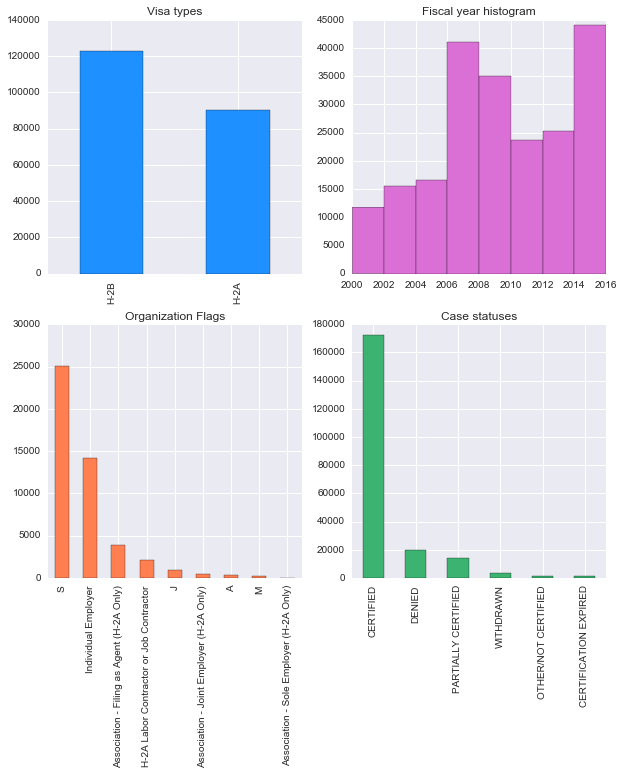

In [12]:
fig = plt.figure(figsize=(10,10))

# plotting the visa_type column distribution
ax1 = fig.add_subplot(2,2,1)
visa["visa_type"].value_counts().plot(kind='bar',title="Visa types",color='dodgerblue')

# plotting the fiscal year column distribution
ax2 = fig.add_subplot(2,2,2)
visa["fy"].hist(color='orchid',bins=8)
plt.title("Fiscal year histogram")

# plotting the organization flag column distribution
ax3 = fig.add_subplot(2,2,3)
visa["organization_flag"].value_counts().plot(kind='bar',title="Organization Flags",color='coral')

# plotting the case status column distribution
ax4 = fig.add_subplot(2,2,4)
visa["case_status"].value_counts().plot(kind='bar',title="Case statuses",color='mediumseagreen')

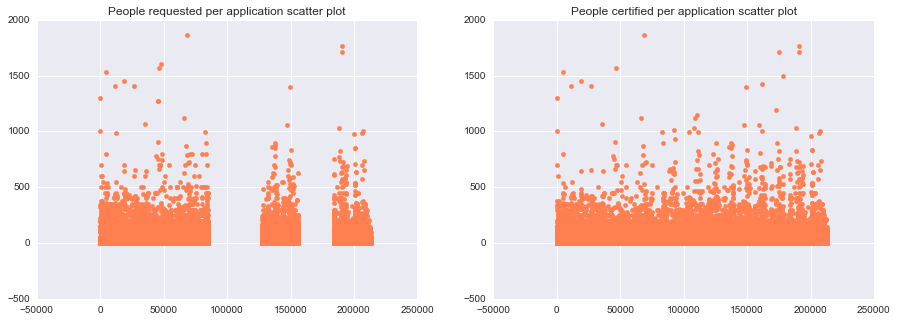

In [13]:
fig = plt.figure(figsize=(15,5))

# making a scatterplot to understand the n_requested column
ax1 = fig.add_subplot(1,2,1)
plt.scatter(x=visa["n_requested"].index,y=visa["n_requested"].values,color='coral')
plt.title("People requested per application scatter plot")

# making a scatterplot of the n_certified column
ax2 = fig.add_subplot(1,2,2)
plt.scatter(x=visa["n_certified"].index,y=visa["n_certified"].values,color='coral')
plt.title("People certified per application scatter plot")

We can see from above that two significant chunks of data are missing from the 'People requested per application' scatter plot.

But it seems to have a similar pattern to the 'People certified per application' scatterplot 

## Data cleaning

In [14]:
# removing duplicates

# First removing duplicate rows using drop_duplicates function
visa_uni = visa.drop_duplicates()
print("Number of duplicate rows removed")
print(visa.duplicated().value_counts()[True])

Number of duplicate rows removed
152


In [15]:
# removing rows where the column "is_duplicate" is marked as True
# The is_duplicate column value will be True — indicating that this row corresponds a sub-application of a joint employer's 
# "master application"

print("Number of rows being removed")
print(visa_uni[visa_uni["is_duplicate"] == True].shape[0])

visa_uni = visa_uni[visa_uni["is_duplicate"] != True]

Number of rows being removed
28025


## Visualizations after the cleaning

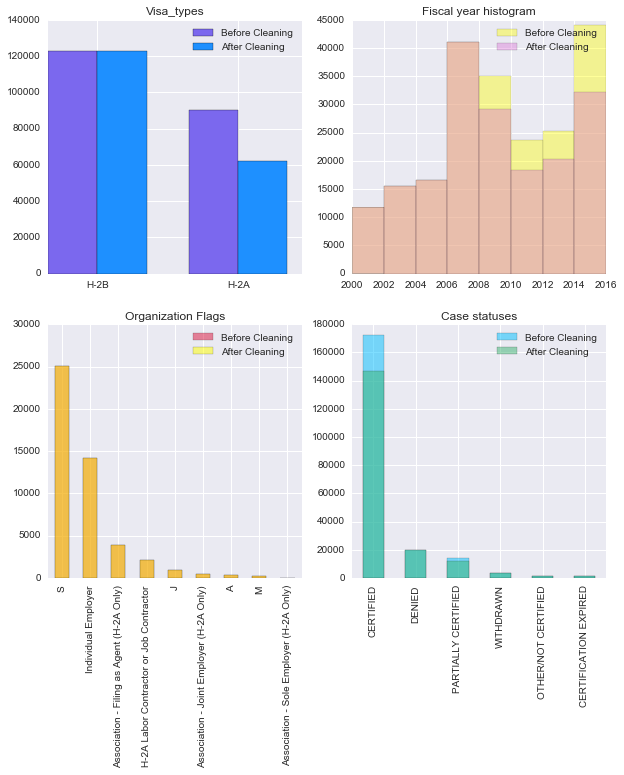

In [16]:
fig = plt.figure(figsize=(10,10))

# visa_type column 
ax1 = fig.add_subplot(2,2,1)
locs_1 = np.arange(2)
off_1 = locs_1 + 0.35
ax1.bar(left=locs_1,height=visa["visa_type"].value_counts().tolist(),color='mediumslateblue',width=0.35)
ax1.bar(left=off_1,height=visa_uni["visa_type"].value_counts().tolist(),color='dodgerblue',width=0.35)
ax1.set_xticklabels(visa["visa_type"].value_counts().index.tolist())
ax1.set_xticks(off_1)
plt.legend(("Before Cleaning","After Cleaning"))
plt.title("Visa_types")
#visa["visa_type"].value_counts().plot(kind='bar',title="Visa types",color='mediumslateblue',alpha=0.5)
#visa_uni["visa_type"].value_counts().plot(kind='bar',title="Visa types",color='dodgerblue',alpha=0.5)

# fiscal year column
ax2 = fig.add_subplot(2,2,2)
visa["fy"].hist(color='yellow',bins=8,alpha=0.4)
visa_uni["fy"].hist(color='orchid',bins=8,alpha=0.4)
plt.title("Fiscal year histogram")
plt.legend(("Before Cleaning","After Cleaning"))

# organization flag column
ax3 = fig.add_subplot(2,2,3)
visa["organization_flag"].value_counts().plot(kind='bar',title="Organization Flags",color='crimson',alpha=0.5)
visa_uni["organization_flag"].value_counts().plot(kind='bar',title="Organization Flags",color='yellow',alpha=0.5)
plt.legend(("Before Cleaning","After Cleaning"))

# case status column
ax4 = fig.add_subplot(2,2,4)
visa["case_status"].value_counts().plot(kind='bar',title="Case statuses",color='deepskyblue',alpha=0.5)
visa_uni["case_status"].value_counts().plot(kind='bar',title="Case statuses",color='mediumseagreen',alpha=0.5)
plt.legend(("Before Cleaning","After Cleaning"))

As we can see, there are a few changes in the graphs after the data has been cleaned

There are NO changes in the Organization Flags plot

## Goal - How has the number of approved applications changed over time?

In [17]:
# making a pivot table to get case_status - fiscal year distribution
visa_uni.loc[:,"case_count"] = 1
year_status = visa_uni.pivot_table(values="case_count",index="case_status",columns="fy",aggfunc=np.sum)
year_status

fy,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
case_status,,,,,,,,,,,,,,,,,
CERTIFICATION EXPIRED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1299,NaN,77
CERTIFIED,4180,5799,6044,6876,7530,6350,15684,17468,13964,8714,6360,6842,7500,8627,8987,11495,4282
DENIED,634,901,1013,1190,1308,771,2255,3963,1090,1389,1062,853,742,678,660,825,411
OTHER/NOT CERTIFIED,85,123,124,204,458,80,483,54,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PARTIALLY CERTIFIED,NaN,NaN,NaN,NaN,NaN,NaN,313,820,1536,2012,1445,1549,1341,1069,827,811,532
WITHDRAWN,14,40,37,46,44,34,NaN,NaN,233,236,99,106,87,308,416,953,634


As we can see above, a lot of values are missing/unavailable/zero, especially for years 2000-2007

So we will now plot certified applications from 2006 on

#### Plotting different application statuses over time 

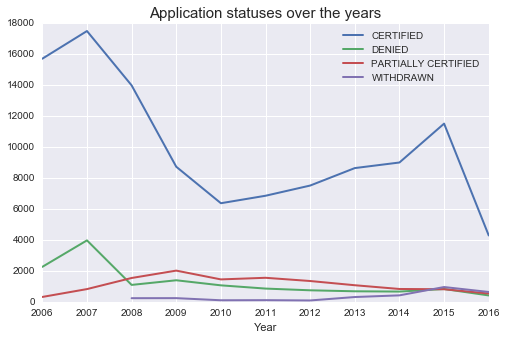

In [18]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.set_xticks(year_status.columns)
ax.set_xlabel("Year")
ax.plot(year_status.loc['CERTIFIED',2006:],linewidth=2)
ax.plot(year_status.loc['DENIED',2006:],linewidth=2)
ax.plot(year_status.loc['PARTIALLY CERTIFIED',2006:],linewidth=2)
ax.plot(year_status.loc['WITHDRAWN',2006:],linewidth=2)
plt.legend()
plt.title("Application statuses over the years",fontsize=15)

Clearly the number of certified applications over the years has shown a decreasing trend in general

The number of denied applications seem to be more of less the same over the years, which seems to the case with partial certified and withdrawn applications as well

Withdrawn applications seem to have a slight rise in 2016

#### Plotting different application statuses over time hued by the visa_type

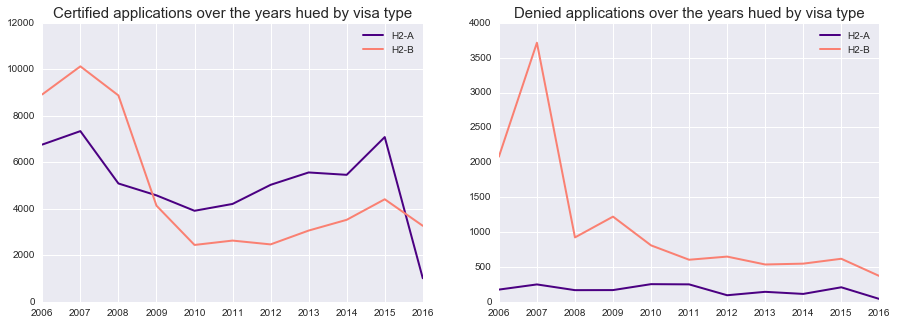

In [19]:
# singling out h2-a and h2b visas separately that are certified
h2a_certified = visa_uni[(visa_uni["visa_type"] == "H-2A") & (visa_uni["case_status"] == "CERTIFIED")]["fy"].value_counts()
h2b_certified = visa_uni[(visa_uni["visa_type"] == "H-2B") & (visa_uni["case_status"] == "CERTIFIED")]["fy"].value_counts()
h2a_certified = h2a_certified.sort_index()
h2b_certified = h2b_certified.sort_index()

# singling out h2-a and h2b visas separately that are denied
h2a_denied = visa_uni[(visa_uni["visa_type"] == "H-2A") & (visa_uni["case_status"] == "DENIED")]["fy"].value_counts()
h2b_denied = visa_uni[(visa_uni["visa_type"] == "H-2B") & (visa_uni["case_status"] == "DENIED")]["fy"].value_counts()
h2a_denied = h2a_denied.sort_index()
h2b_denied = h2b_denied.sort_index()

fig = plt.figure(figsize = (15,5))

# plotting certified applications graph
ax1 = fig.add_subplot(1,2,1)
ax1.set_xticks(range(2006,2017))
# plotting the numbers from year 2006 on, to keep it uniform since h2_b data has a 2001 row
ax1.plot(h2a_certified,label="H2-A",color='indigo',linewidth=2)
ax1.plot(h2b_certified.loc[2006:],label="H2-B",color='salmon',linewidth=2)
plt.legend()
plt.title("Certified applications over the years hued by visa type",fontsize=15)

# plotting the denied applications graph
ax2 = fig.add_subplot(1,2,2)
ax2.set_xticks(range(2006,2017))
ax2.plot(h2a_denied,label="H2-A",color='indigo',linewidth=2)
ax2.plot(h2b_denied.loc[2006:],label="H2-B",color='salmon',linewidth=2)
plt.legend()
plt.title("Denied applications over the years hued by visa type",fontsize=15)


As we can see, when we hue the certified applications by visa type, it shows a slight different trend for each visa type

But the general trend remains the same, which is decreasing over the years.

The denied applications, on the other hand seems to follow an interesting trend.

For H2-A applications, the trend seems to be more or less the same over the years
For H2-B applications, there seems to be a drastic decline after 2007 and from 2011 until 2016, it seems to be more or less constant.

Also, its worth noticing that the number of declined applications seems to be converging for both application types as time goes by and the gap between them has bridged considerably

## Goal - How have the number of approved workers changed over time?

In [20]:
# making a pivot table to get number of people certified for all the years
year_certified = visa_uni.pivot_table(values="n_certified",index="fy",aggfunc=np.sum)
year_certified

fy
2000     88588
2001    115413
2002    121865
2003    144361
2004    168054
2005    134787
2006    272289
2007    344210
2008    344703
2009    247891
2010    165799
2011    160768
2012    160695
2013    181120
2014    210337
2015    241490
2016    104026
Name: n_certified, dtype: int64

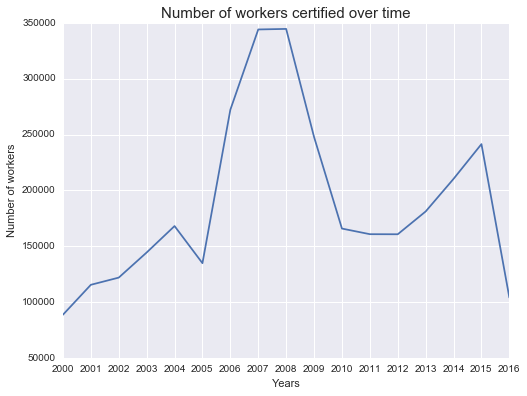

In [21]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.plot(year_certified)
ax.set(xticks = range(2000,2017), xlabel = "Years", ylabel = "Number of workers")
plt.title("Number of workers certified over time",fontsize=15)
plt.show()

It looks like the number of certified workers reached a peak in about 2007-2008 and then decreased (It could be because of the economic recession)

There is another minor peak in 2015 after which it seems to have dropped significanly again in 2016

## Goal - Which locations and types of businesses request the most visas and how has this changed over time?

In [22]:
# exploring the worksite_state column

states = visa_uni["worksite_state"].value_counts()
states.head()

TX    11272
LA     8425
KY     7811
NY     6985
FL     5964
Name: worksite_state, dtype: int64

In [23]:
# plotting the total number of requests in all the years by state

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

In [24]:
data = [ dict(
        type='choropleth',
        locations = states.index,
        z = states.values.astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Number of Requests"
        )
    ) ]

In [25]:
layout = dict(
        title = 'Number of visa requests per state',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )
    
fig = dict( data=data, layout=layout )

url = py.plot( fig, filename='h2map' )
tls.embed(url)

Please note that github doesn't support ipython rendering for plotly plots, so to view the plotly plots, go to the below link
http://nbviewer.jupyter.org/github/chrke/H2VisaAnalysis/blob/master/H2_visa_analysis.ipynb

Clearly Texas seems to be the state with highest requests

How has this changed over time?

In [26]:
year_state = visa_uni.pivot_table(values="case_count",index="worksite_state",columns="fy",aggfunc=np.sum)
year_state.head()

fy,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
worksite_state,,,,,,,,,,
AB,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AK,32,49,48,49,59,65,67,83,99,28
AL,198,140,114,68,63,129,103,112,118,53
AR,252,207,188,154,164,183,196,203,221,85
AS,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN


### Number of requests per state in 2007

In [27]:
data = [ dict(
        type='choropleth',
        locations = year_state.index,
        z = year_state.loc[:,2007].values.astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Number of Requests is 2007"
        )
    ) ]

In [28]:
layout = dict(
        title = 'Number of visa requests per state in 2007',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )
    
fig = dict( data=data, layout=layout )

url = py.plot( fig, filename='h2map_2007' )
tls.embed(url)

Clearly, even in 2007, Texas seems to be the highest requesting state, with Florida, North Carolina appearing to be next major contributors, followed by states like Newyork, California, Colorado, Virginia, Massachussets, Louisiana and Kentucky

### Number of requests per state in 2012

In [29]:
data = [ dict(
        type='choropleth',
        locations = year_state.index,
        z = year_state.loc[:,2012].values.astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Number of Requests is 2012"
        )
    ) ]

In [30]:
layout = dict(
        title = 'Number of visa requests per state in 2012',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )
    
fig = dict( data=data, layout=layout )

url = py.plot( fig, filename='h2map_2012' )
tls.embed(url)

In 2012, Texas still seems to be the highest requesting state, with similar number of requests from Louisiana and Kentucky
followed by Newyork, Idaho, Massachussets, Colorado and North Dakota

### Number of requests per state in 2016

In [31]:
data = [ dict(
        type='choropleth',
        locations = year_state.index,
        z = year_state.loc[:,2016].values.astype(float),
        locationmode = 'USA-states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Number of Requests is 2016"
        )
    ) ]

In [32]:
layout = dict(
        title = 'Number of visa requests per state in 2016',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )
    
fig = dict( data=data, layout=layout )

url = py.plot( fig, filename='h2map_2016' )
tls.embed(url)

Texas still stands out, followed by Louisiana and Florida (This slightly resembles the total number of requests)
followed by Colorado and Newyork

In [33]:
org_year = visa_uni.pivot_table(values="case_count",index="organization_flag",columns="fy",aggfunc=np.sum)
org_year

fy,2008,2009,2010,2011,2012,2013,2014,2015,2016
organization_flag,,,,,,,,,
A,66,73,65,55,89,6,NaN,NaN,NaN
Association - Filing as Agent (H-2A Only),NaN,NaN,NaN,NaN,NaN,1001,1314,1440,145
Association - Joint Employer (H-2A Only),NaN,NaN,NaN,NaN,NaN,114,144,194,10
Association - Sole Employer (H-2A Only),NaN,NaN,NaN,NaN,NaN,3,6,7,3
H-2A Labor Contractor or Job Contractor,NaN,NaN,NaN,NaN,NaN,434,660,828,151
Individual Employer,NaN,NaN,NaN,NaN,NaN,3636,4601,5094,812
J,273,141,182,118,159,10,NaN,NaN,NaN
M,57,100,45,NaN,NaN,NaN,NaN,NaN,NaN
S,5246,4953,4139,4768,5211,768,NaN,NaN,NaN


A lot of data is missing/zero in the above pivot table. For whatever data is available, we can plot the trends lines

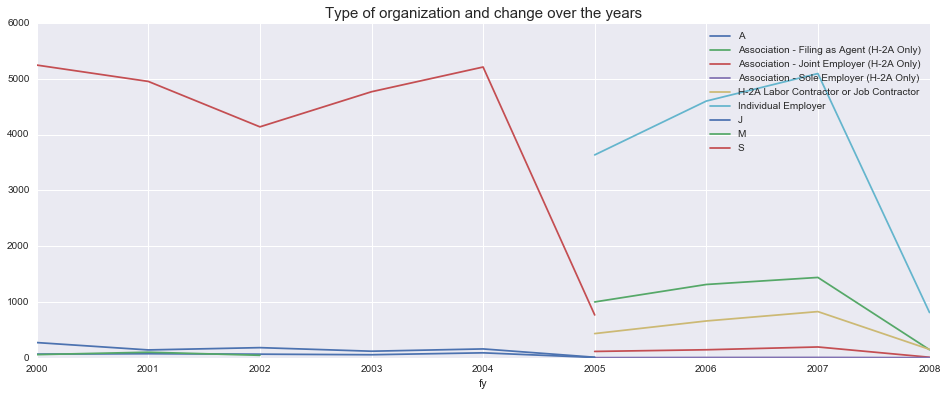

In [34]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,1,1)
ax.set(xticklabels=range(2000,2017),xlabel="Years")
for ind in org_year.index:
    org_year.loc[ind,:].plot(kind='line')
plt.title("Type of organization and change over the years",fontsize=15)
plt.legend()
plt.show()

## Goal - Which positions are the most frequently requested for these visas?

In [35]:
visa_uni["job_title"].value_counts().head()

LABORER, LANDSCAPE       24595
CLEANER, HOUSEKEEPING     6560
LANDSCAPE LABORER         4942
STABLE ATTENDANT          4191
KITCHEN HELPER            2918
Name: job_title, dtype: int64

After researching a bit, I came to the conclusion that trying to organize the job titles into categories isn't an easy task.
So I decided to go into it later. For now, I will work on the top 30 job titles

In [36]:
top_30 = visa_uni["job_title"].value_counts().head(30)
top_30

LABORER, LANDSCAPE                      24595
CLEANER, HOUSEKEEPING                    6560
LANDSCAPE LABORER                        4942
STABLE ATTENDANT                         4191
KITCHEN HELPER                           2918
FARMWORKER, DIVERSIFIED CROP             2753
FARMWORKERS AND LABORERS, CROP           2710
CONSTRUCTION WORKER I                    2650
CONSTRUCTION WORKER II                   2472
GROUNDSKEEPER, INDUSTRIAL COMMERCIAL     2457
COOK                                     2213
FARMWORKER                               2154
FARM WORKERS & LABORERS, CROP            2078
DINING ROOM ATTENDANT                    2060
SHEEP HERDER                             2048
HOUSEKEEPER                              1905
FARM WORKER                              1633
AGRICULTURAL EQUIPMENT OPERATOR          1529
NONFARM ANIMAL CARETAKERS                1447
SHEEPHERDER                              1422
FOREST WORKER                            1345
HORTICULTURAL WORKER II           

As we can see, a lot of titles are repeated, lets try and concise it further

In [37]:
farm_list = ["FARMWORKER, DIVERSIFIED CROP","FARMWORKERS AND LABORERS, CROP","FARMWORKER","FARM WORKERS & LABORERS, CROP",
             "FARM WORKER","FARM WORKER; DIVERSIFIED CROPS II","FARM LABOR","FARMWORKERS, FARM AND RANCH ANIMALS"]
landscape_list = ["LABORER, LANDSCAPE","LANDSCAPE LABORER"]
housekeeping_list = ["CLEANER, HOUSEKEEPING","HOUSEKEEPER"]
construction_list = ["CONSTRUCTION WORKER I","CONSTRUCTION WORKER II"]

new_index = []
for ind in top_30.index:
    if ind in farm_list:
        ind = "FARM WORKER"
    if ind in landscape_list:
        ind = "LANDSCAPE LABORER"
    if ind in housekeeping_list:
        ind = "HOUSEKEEPING"
    if ind in construction_list:
        ind = "CONSRUCTION WORKER"
    else:
        pass
    new_index.append(ind)
top_30.index = new_index

In [38]:
top_30

LANDSCAPE LABORER                       24595
HOUSEKEEPING                             6560
LANDSCAPE LABORER                        4942
STABLE ATTENDANT                         4191
KITCHEN HELPER                           2918
FARM WORKER                              2753
FARM WORKER                              2710
CONSRUCTION WORKER                       2650
CONSRUCTION WORKER                       2472
GROUNDSKEEPER, INDUSTRIAL COMMERCIAL     2457
COOK                                     2213
FARM WORKER                              2154
FARM WORKER                              2078
DINING ROOM ATTENDANT                    2060
SHEEP HERDER                             2048
HOUSEKEEPING                             1905
FARM WORKER                              1633
AGRICULTURAL EQUIPMENT OPERATOR          1529
NONFARM ANIMAL CARETAKERS                1447
SHEEPHERDER                              1422
FOREST WORKER                            1345
HORTICULTURAL WORKER II           

In [39]:
top_df = pd.DataFrame(data=top_30).reset_index()
top_df.columns= ["Job title","Count"]
top_df.head()

,Job title,Count
0,LANDSCAPE LABORER,24595
1,HOUSEKEEPING,6560
2,LANDSCAPE LABORER,4942
3,STABLE ATTENDANT,4191
4,KITCHEN HELPER,2918


In [40]:
top_requests = top_df.pivot_table(values="Count",aggfunc=np.sum,index="Job title").sort_values()
top_requests

Job title
ANIMAL CARETAKER                          896
FARM MACHINE OPERATOR                     903
WAITER/WAITRESS, INFORMAL                 906
DECKHAND, FISHING VESSEL                  947
INSTRUCTOR, SPORTS                       1080
HORTICULTURAL WORKER II                  1285
FOREST WORKER                            1345
SHEEPHERDER                              1422
NONFARM ANIMAL CARETAKERS                1447
AGRICULTURAL EQUIPMENT OPERATOR          1529
SHEEP HERDER                             2048
DINING ROOM ATTENDANT                    2060
COOK                                     2213
GROUNDSKEEPER, INDUSTRIAL COMMERCIAL     2457
KITCHEN HELPER                           2918
STABLE ATTENDANT                         4191
CONSRUCTION WORKER                       5122
HOUSEKEEPING                             8465
FARM WORKER                             14812
LANDSCAPE LABORER                       29537
Name: Count, dtype: int64

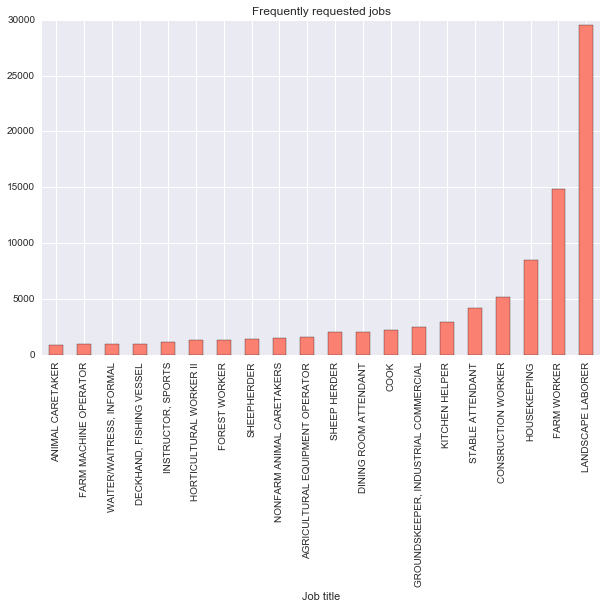

In [41]:
fig = plt.figure(figsize=(10,6))
top_requests.plot(kind="bar",color='salmon')
plt.title("Frequently requested jobs")
plt.show()

This obviously is not a very good way of doing it. More work to be done on categorizing these job titles

## Goal - Is there a correlation between the length of the period the employee is expected to work for and the final decision?

In [42]:
# According to the documentation, "Certification begin and end dates are unavailable for H-2B data prior to FY2007"
# lets explore the values and see if that is true

# how many rows have certification begin and end date missing and what is their distribution by visa_type and year

print("---Certification begin date missing---\n")
print(visa_uni[pd.isnull(visa_uni["certification_begin_date"])].pivot_table(values="case_count",index="fy",columns='visa_type'
                                                                      ,aggfunc=np.sum))

print("\n\n---Certification end date missing ---\n")
print(visa_uni[pd.isnull(visa_uni["certification_end_date"])].pivot_table(values="case_count",index="fy",columns='visa_type'
                                                                      ,aggfunc=np.sum))


---Certification begin date missing---

visa_type  H-2A   H-2B
fy                    
2000        NaN   4913
2001        NaN   6863
2002        NaN   7218
2003        NaN   8316
2004        NaN   9340
2005        NaN   7235
2006        653  11267
2007          2     11
2008        399      2
2009        404    NaN
2010        352      5
2011        356      6
2012        181      4
2013         64      1
2014          2      4
2015          7      5
2016          1      5


---Certification end date missing ---

visa_type  H-2A   H-2B
fy                    
2000        NaN   4913
2001        NaN   6863
2002        NaN   7218
2003        NaN   8316
2004        NaN   9340
2005        NaN   7235
2006        653  11267
2007          2     12
2008        399      1
2009        404    NaN
2010        352      7
2011        356      6
2012        181      5
2013         64      2
2014          3      7
2015          6      5
2016          1      3


On a cursory look, we can see that a lot of these missing values belong to H2B and from years older than 2007

But we can also see that a significant number of values are missing from H-2A visa type from years 2008 and later. 
It also looks like these rows are missing both the begin date and end date as a pair.

Let's calculate the certification period using the certification begin and end dates and see if we can fill the gaps with a logically derived value.

In [43]:
# first converting these columns to datetime type

visa_uni["certification_begin_date"] = pd.to_datetime(visa_uni["certification_begin_date"])
visa_uni["certification_end_date"] = pd.to_datetime(visa_uni["certification_end_date"])

# adding a column "certification_period" to specity how long the employee was expected to work for 
# note here, that the subtraction will yield an value which is of the TimeDelta datatype, which is of the format - (days, hours,
# mins, seconds). We can extract only the number of days from that and convert it to an integer

visa_uni.loc[:,"certification_period"] = visa_uni["certification_end_date"] - visa_uni["certification_begin_date"]


#function to extract the days
def extract_days(x):
    try:
        return pd.to_timedelta(x).days
    except:
        return np.nan

# applying the function
visa_uni.loc[:,"certification_period"] = visa_uni["certification_period"].apply(extract_days)

# also making a column called status code with certified and partially certified rows marked as - 1 (certified) 
# and the rest as 0 (not certified)
visa_uni.loc[:,"status_code"] = visa_uni["case_status"].map({"CERTIFIED":1,"PARTIALLY CERTIFIED":1,"DENIED":0,"WITHDRAWN":0,
                                                    "CERTIFICATION EXPIRED":0,"OTHER/NOT CERTIFIED":0})

count    127350.000000
mean        244.279529
std         145.580964
min      -25265.000000
25%         204.000000
50%         258.000000
75%         299.000000
max       33069.000000
Name: certification_period, dtype: float64


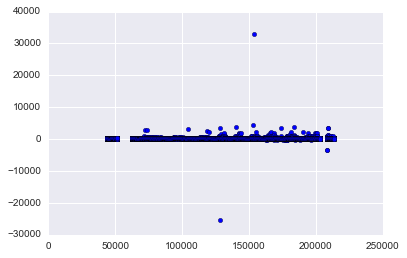

In [44]:
# lets check the summary statistics and scatter plot for certification period to see if there are any outliers

print(visa_uni["certification_period"].describe())
plt.scatter(x=visa_uni.index,y=visa_uni["certification_period"].values)

Clearly there are outliers, and also some negative values. Now, negative values aren't right, because we calculated the period between the end and the start dates. Checking the the number of rows with negative values

In [45]:
print("--Number of rows having negative certification periods--\n")
print(len(visa_uni[visa_uni["certification_period"] < 0 ]))

print("\n--Number of rows with abnormally large certification periods--\n")
print(len(visa_uni[visa_uni["certification_period"] > 1100 ]))
# capping the maximum at 1100 days

--Number of rows having negative certification periods--

52

--Number of rows with abnormally large certification periods--

55


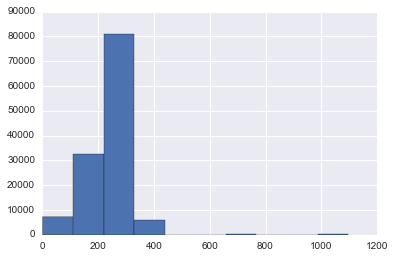

In [46]:
# deleting these rows as well as all the null value rows 

cert_df = visa_uni[(visa_uni["certification_period"] > 0 ) & (visa_uni["certification_period"] < 1100)]
cert_df["certification_period"].hist()

In [ ]:
sns.lmplot("certification_period","status_code",cert_df)

sns.lmplot("certification_period","status_code",cert_df,hue="visa_type")

*Insights*

1) We can clearly see a downward trend, with very little standard deviation. This goes to signify that as the certification period increases, there is higher possibility of the request being rejected rather than being certified

2) When we see it hued by the visa type, H-2A and H-2B visa types have opposite trends with respect to the certification period. H-2A visas seem to have a positive correlation with the certification period signifying that as the certification period increases, there is a higher chance of the visa being certified

3) H-2B visas have a negative correlation, signifying that as the certification period increases, there are lesser chances of the visa being certified